# Support Vectors Machines and optimization

<p style='text-align: right;font-style: italic;'>Designed by: Dr. Abdelkrime Aries</p>

In this lab, we will learn about two concpts:
- Support Vectors Machines (primal and dual forms)
- Optimization (stochastic gradient descent and Sequential minimal optimization)

In [1]:
import matplotlib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.25.2', '2.0.3', '3.7.1')

In [2]:
from datetime import datetime
import random
import timeit
import sys
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

datetime.now()

datetime.datetime(2024, 6, 25, 13, 9, 57, 951044)

In [3]:
import sklearn

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn import datasets

sklearn.__version__

'1.2.2'

In [4]:
# calculate the size of an object with these components
# code taken from this link
# https://stackoverflow.com/a/40880923/2296914
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

## I. Algorithms implementation

In this section, we will try to implement multinomial Naive Bayes.

**>> Try to use "numpy" which will save a lot of time and effort**

### I.1. Primal SVM

Here, we will try to implement the primal form of SVMs for binary classification.
It is very similar to logistic regrssion.

#### I.1.1. Estimation function

The estimation function uses weighted sum to estimate the side (positive or negative):
$$ h^{(i)} = b + \sum_{j=1}^{N} w_j x_j^{(i)} $$

with $(i)$ the ith sample

In [5]:
# TODO: Primal SVM estimation function
def primal_hf(X: np.ndarray, W: np.ndarray = None,b: float = 0.0) -> np.ndarray:
      if W is None:
           W = np.zeros(X.shape[1])
      return np.dot(X, W) + b

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array([-0.5,  1. ,  2.5])
#---------------------------------------------------------------------

X_t     = np.array([[2. , -10. ],
                    [1. , - 2. ],
                    [1.5,   3. ]])
w_t = np.array([ 0.5,   0.25])
b_t = 1.
H       = primal_hf(X_t, w_t, b_t)
H

array([-0.5,  1. ,  2.5])

#### I.1.2. Cost function

We will implement soft margin using **Hinge** cost function:
$$ J = \frac{C}{2M} \sum\limits_{i=0}^{M} \max(0, 1- y^{(i)} h^{(i)})$$
where:
- $M$: Number of samples with $(i)$ the ith sample
- $N$: Number of features
- $h^{(i)}$: the estimated direction of the ith sample
- $C$: is a hypr-paramters with two objectives; maximize the margin or minimize the number of errors. Modifying C means prefering one objevtive over the other.


In [6]:
# TODO: Primal SVM cost
def J_hinge(H    : 'np.ndarray(M)[float]',
            Y    : 'np.ndarray(M)[float]',
            C    : 'float' = 1.
            ) -> 'float':
    M = np.size(Y)
    res = 0
    for i in range(M):
            res += np.maximum(0,1-(Y[i] * H[i]))
    return res * C/(2*M)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.3333333333333333
#---------------------------------------------------------------------

Z_t = np.array([-1.5,  0.,  1.5])
Y_t = np.array([ 0. ,  1.,  1. ])

J_hinge(Z_t, Y_t, C=1.)

0.3333333333333333

#### I.1.2. Gradient function

**Hinge** gradient is calculated as follows:
$$ \frac{\partial J}{\partial w_j} =
\frac{1}{M} \sum\limits_{i=1}^M \begin{cases}
0 & \text{if } y^{(i)} h^{(i)} \ge 1\\
- C x^{(i)}_j y^{(i)} & \text{otherwise}  \\
\end{cases}$$
$$ \frac{\partial J}{\partial b} =
\frac{1}{M} \sum\limits_{i=1}^M \begin{cases}
0 & \text{if } y^{(i)} h^{(i)} \ge 1\\
- C y^{(i)} & \text{otherwise}  \\
\end{cases}$$
where:
- $M$: Number of samples with $(i)$ the ith sample
- $N$: Number of features
- $\theta_j$: is the feature $j$'s parameter
- $C$: is a hypr-paramters with two objectives; maximize the margin or minimize the number of errors. Modifying C means prefering one objective over the other.

Given $z^{(i)} = \theta_0 + \sum_{j=1}^{N} \theta_j x_j^{(i)}$

**HINT**
```
# A[M]  => A.reshape(-1, 1) = A'[M, 1]
# A[M]  => A[:, np.newaxis] = A'[M, 1]
# A[M, 1] => np.repeat(A, N, axis=1) = A'[M, N] (each row will have the same value for its columns)
# A[M, N] bool, B[M, N], C[M, N] => np.where(A, B, C) = D[M, N] a matrix having elements of B or C following the truth of A
```

In [7]:
# TODO: Primal SVM gradient
def dJ_hinge(X: 'np.ndarray(M,N)[float]',
             H: 'np.ndarray(M)[float]'  ,
             Y: 'np.ndarray(M)[float]'  ,
             C: 'float' = 1.
            )    -> Tuple['np.ndarray(M)[float]', 'float']:


    M,N = X.shape
    # matrice [M,N] remplie de zéros
    zeros = np.zeros_like(X)
    # matrice [M,N] remplie avec : -C*x[i,j]*y[i]
    Y2 = np.repeat(Y.reshape(-1,1),N,axis=1)
    CXY = -C*np.multiply(X,Y2)
    # matrice de booleéns (y*z >=1)
    cond = np.repeat(np.array(np.multiply(Y,H) >= 1).reshape(-1,1),N,axis=1)
    res = np.where(cond,zeros,CXY)


    M = X.shape[0]  # Number of samples

    # Initialize arrays
    zeros = np.zeros(M)

    # Create condition matrix (boolean)
    cond = (Y * H >= 1)

    # Calculate the bias gradient ∂J/∂b
    grad_b = (1 / M) * np.sum(np.where(cond, 0, -C * Y))


    return (1/M)*np.sum(res,axis=0), grad_b


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([ 0.8, -1.6]), 0.4)
#---------------------------------------------------------------------

X_t = np.array([[1., -5.],
                [2., -4.],
                [3., -3.],
                [4., -2.],
                [5., -1.]])
H_t = np.array([-1.5, 1.5, 0.5, -0.5, 0.2])
Y_t = np.array( [-1. , -1., -1., -1., 1.])

dJ_hinge(X_t, H_t, Y_t)

(array([ 0.8, -1.6]), 0.4)

#### I.1.3. Gradient descent variants

**>> Nothing to code here**

Here we implemented three variations of gradient descent:
- **GD**: The normal gradient descent with the subgradients of all samples. For each iteration, the parameters are updated using the average of the subgradients over the entire dataset.
- **SGD**: The stochastic gradient descent. For each iteration, a sample (observation) is chosen randomly. The parameters are updated based only on the gradients of this sample.
- **SGDA**: A version of stochastic gradient descent that we proposed for comparison. For each iteration, the parameters are updated on each sample in a random manner. When exiting the samples loop, the iteration error is calculated on all samples after the last parameter update.

In [8]:
def J_L2(W: 'np.ndarray(N)[float]', M: 'int') -> 'float':
    return np.sum(W**2)/(2*M)

def dJ_L2(W: 'np.ndarray(N)[float]', M: 'int') -> 'np.ndarray(N)[float]':
    return  W/M

def init_params(N: int) -> Tuple['np.ndarray(N)[float]', float]:
    return np.zeros(N), 0.

# Gradient Descent
def GD_svm(X       : 'np.ndarray(M,N)[float]',
           Y       : 'np.ndarray(M)[float]'  ,
           max_iter: int   = 100             ,
           alpha   : float = 0.1             ,
           C       : float = 1.
           ) -> Tuple[List['np.ndarray(N)[float]'], float, List['float']]:

    costs = []
    M     = len(Y)
    W, b  = init_params(X.shape[1])

    for it in range(max_iter):
        H      = primal_hf(X, W, b)
        dW, db = dJ_hinge(X, H, Y, C=C)
        W -= alpha * (dJ_L2(W, M) + dW)
        b -= alpha * db
        # recalculate the output using the updated weights
        H      = primal_hf(X, W, b)
        costs.append(J_L2(W, M) + J_hinge(H, Y, C=C))

    return W, b, costs



# Stochastic Gradient Descent
def SGD_svm(X      : 'np.ndarray(M,N)[float]',
            Y       : 'np.ndarray(M)[float]'  ,
            max_iter: 'int'   = 100           ,
            alpha   : 'float' = 0.1           ,
            C       : 'float' = 1.
            ) -> Tuple[List['np.ndarray(N)[float]'], List['float']]:

    M     = len(X)
    costs = []
    W, b  = init_params(X.shape[1])

    for it in range(max_iter):
        # Mettre à jours les paramettres sur un seul échantillon choisi aléatoirement
        i      = random.randint(0, M-1)
        X_i    = np.array([X[i, :]])
        Y_i    = np.array([Y[i]])
        H_i    = primal_hf(X_i, W, b)
        dW, db = dJ_hinge(X_i, H_i, Y_i, C=C)
        W -= alpha * (dJ_L2(W, M) + dW)
        b -= alpha * db

        # Ici, on va calculer l'erreur sur tous les échantillons (dataset complet)
        # et pas seulement l'échantillon choisi aléatoirement
        # puisqu'on veut savoir l'erreur globale pour la comparer avec les autres méthodes
        H      = primal_hf(X, W, b)
        costs.append(J_L2(W, M) + J_hinge(H, Y, C=C))

    return W, b, costs

# Stochastic Gradient Descent using All samples
def SGDA_svm(X       : 'np.ndarray(M,N)[float]',
             Y       : 'np.ndarray(M)[float]'  ,
             max_iter: 'int'   = 100           ,
             alpha   : 'float' = 0.1           ,
             C       : 'float' = 1.
             ) -> Tuple[List['np.ndarray(N)[float]'], List['float']]:

    M     = len(X)
    costs = []
    W, b  = init_params(X.shape[1])

    for it in range(max_iter):
        idx = np.random.permutation(M)
        for i in idx:
            X_i    = np.array([X[i, :]])
            Y_i    = np.array([Y[i]])
            H_i    = primal_hf(X_i, W, b)
            dW, db = dJ_hinge(X_i, H_i, Y_i, C=C)
            W -= alpha * (dJ_L2(W, M) + dW)
            b -= alpha * db

        H      = primal_hf(X, W, b)
        costs.append(J_L2(W, M) + J_hinge(H, Y, C=C))

    return W, b, costs

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([-0.0912174 ,  0.77411969]),
#  array([0.59730392, 1.04510798]),    <-- changes randomly
#  array([-0.01994985,  0.84338404]))  <-- changes randomly
#---------------------------------------------------------------------

X_t = np.array([[0.02, -0.10],
                [0.01, -0.02],
                [0.15,  0.03]])
Y_t = np.array([-1., 1., 1.])

W_t1, b_t1, costs_t1 = GD_svm  (X_t, Y_t, C=10.)
W_t2, b_t2, costs_t2 = SGD_svm (X_t, Y_t, C=10.)
W_t3, b_t3, costs_t3 = SGDA_svm(X_t, Y_t, C=10.)
W_t1, W_t2, W_t3

(array([-0.0912174 ,  0.77411969]),
 array([0.29304208, 0.73892063]),
 array([0.04980296, 0.85595693]))

### I.2. Dual SVM

Our prdication function is calculated as:
$$ f(X) = \sum\limits_{i=1}^{M} \theta X^{(i)} + \theta_0$$

$\theta$ can b formulated as ([Hilary, A. Zisserman (2015), Lecture 3: SVM dual, kernels and regression](http://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf)):
$$ \theta = \sum\limits_{i=1}^{M} \alpha_i X^{(i)} Y^{(i)}$$

The dual form of the problem will be:
$$\max\limits_{\alpha_i \ge 0} \sum\limits_{i=1}^{M} \alpha_i - \frac{1}{2} \sum\limits_{i=1}^{M} \sum\limits_{j=1}^{M} \alpha_i \alpha_j y^{(i)} y^{(j)} x^{(i)} x^{(j)}$$
under the constraints:
$$0 \le \alpha_i \le C$$
$$\sum\limits_{i=1}^{M} \alpha_i y^{(i)} = 0$$

#### I.2.1. Kernel

**>> Nothing to code here**

Let us note $K(x^{(i)}, x^{(j)}) = x^{(i)} x^{(j)}$ which is called: "Linear kernel".

The idea of the kernel is to seek a linear separation of the problem in a higher dimensional space.
This is accomplished by applying a nonlinear function on the input vectors $X$.

Gaussian kernel (RBF kernel):
$$K(x_1, x_2) = exp{(-\frac{||x_1 - x_2||^2}{2 \sigma^2})} = exp{(-\frac{\sum_i (x_1^{(i)} - x_2^{(i)})^2}{2 \sigma^2})}$$

In [9]:
def linear(X1: 'np.ndarray(M,N)[float]',
           X2: 'np.ndarray(M,N)[float]') -> 'np.ndarray(M,M)[float]':
    return np.dot(X1, X2.T)

def RBF(X1   : 'np.ndarray(M,N)[float]',
        X2   : 'np.ndarray(M,N)[float]',
        sigma: 'float' = 1) -> 'np.ndarray(M,M)[float]':
    # Le cas de calcul du kernel entre deux échantillons (entraînement)
    # résultat: un scalar
    if np.ndim(X1) == 1 and np.ndim(X2) == 1:
        result = np.exp(- (np.linalg.norm(X1 - X2, 2)) ** 2 / (2 * sigma ** 2))
    # Le cas de calcul du kernel
    elif (np.ndim(X1) > 1 and np.ndim(X2) == 1) or (np.ndim(X1) == 1 and np.ndim(X2) > 1):
        result = np.exp(- (np.linalg.norm(X1 - X2, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(X1) > 1 and np.ndim(X2) > 1:
        result = np.exp(- (np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([[ 9,  6,  3],
#         [23, 16,  9],
#         [37, 26, 15]]),
#  array([[29, 22, 15],
#         [22, 17, 12]]),
#  array([[3.35462628e-04, 6.73794700e-03, 1.83156389e-02],
#         [1.83156389e-02, 6.73794700e-03, 3.35462628e-04],
#         [3.35462628e-04, 2.26032941e-06, 2.06115362e-09]]),
#  array([[1.        , 0.36787944, 0.01831564],
#         [0.36787944, 1.        , 0.36787944]]))
#---------------------------------------------------------------------

X1_t = np.array([ # X1[3, 2]
    [1, 2],
    [3, 4],
    [5, 6]
])

X2_t = np.array([ # X2[3, 2]
    [5, 2],
    [4, 1],
    [3, 0]
])

X3_t = np.array([ # X3[2, 2]
    [5, 2],
    [4, 1]
])

linear(X1_t, X2_t), \
linear(X3_t, X2_t), \
RBF   (X1_t, X2_t), \
RBF   (X3_t, X2_t)

(array([[ 9,  6,  3],
        [23, 16,  9],
        [37, 26, 15]]),
 array([[29, 22, 15],
        [22, 17, 12]]),
 array([[3.35462628e-04, 6.73794700e-03, 1.83156389e-02],
        [1.83156389e-02, 6.73794700e-03, 3.35462628e-04],
        [3.35462628e-04, 2.26032941e-06, 2.06115362e-09]]),
 array([[1.        , 0.36787944, 0.01831564],
        [0.36787944, 1.        , 0.36787944]]))

#### I.2.3. Estimation function

$$\hat{y_t} = f(x_t) = \sum^M_{i=1} \alpha_i y^{(i)} K(x^{(i)}, x_t) - b$$
Where,
- $x$: training samples
- $x_t$: test samples

In [10]:
# TODO: Dual SVM estimation
def dual_hf(X_test : 'np.ndarray(M2,N)[float]',
           X_train: 'np.ndarray(M1,N)[float]'= None,
           Y_train: 'np.ndarray(M1)[float]' = None ,
           alphas : 'np.ndarray(M1)[float]' = None ,
           b      : 'float'                 =0 ,
           K      : 'fonction' = linear
          )      -> 'np.ndarray(M2)[float]':


    final_res = np.zeros(len(X_test))
    for i in range(len(X_test)):
        res = 0
        for j in range(len(Y_train)):
            res += (alphas[j] * Y_train[j]) * K(X_train[j],X_test[i])
        final_res[i] = res - b
    return final_res
#=====================================================================
# UNIT TEST
#=====================================================================
# Resultat :
# array([-0.28287917, -0.54510201])
#---------------------------------------------------------------------

a_t = np.array([1., .5, .25])
X_t = np.array([
    [1., 2.],
    [2., 3.],
    [2., 1.]])
Y_t = np.array([1, -1, 1])
X_tt = np.array([
    [1., 1.],
    [2., 2.]])

dual_hf(X_tt, X_t, Y_t, a_t, 1., K=RBF)

array([-0.28287917, -0.54510201])

#### I.2.2. Objective function

We want to maximize this objective function:
$$W(\alpha) = \sum\limits_{i=1}^{M} \alpha_i - \frac{1}{2} \sum\limits_{i=1}^{M} \sum\limits_{j=1}^{M} \alpha_i \alpha_j y^{(i)} y^{(j)} K(x^{(i)}, x^{(j)})$$

In [11]:
def J_dual(X     : 'np.ndarray(M,N)[float]',
           Y     : 'np.ndarray(M)[float]'  ,
           alphas: 'np.ndarray(M)[float]'  ,
           K     : 'fonction' = linear
          )     -> 'float':
    alpha_sum = np.sum(alphas)
    M = X.shape[0]
    double_sum = 0
    double_sum = np.sum([alphas[i]*alphas[j]*Y[i]*Y[j]*K(X[i],X[j]) for i in range(M) for j in range(M)])
    return alpha_sum - (1/2) * double_sum


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 1.2026367706974372
#---------------------------------------------------------------------

X_t = np.array([[1., 2.],
                [2., 3.],
                [2., 1.]])
Y_t = np.array([1, -1,  1])
a_t = np.array([1., .5, .25])

J_dual(X_t, Y_t, a_t, K=RBF)

1.2026367706974372

#### I.2.4. Sequential minimal optimization

**>> Nothing to code here**

To maximize the objective function, we used the method [Sequential minimal optimization](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

The next code is an adaptation of [Implementing a Support Vector Machine using Sequential Minimal Optimization and Python 3.5](https://jonchar.net/notebooks/SVM/#Sequential-minimal-optimization)

In [12]:
def execute_step(X, Y, alphas, b, errors, K, C, i1, i2, tol, eps):

    # If chosen alphas are the same ==> exit
    if i1 == i2:
        return False, b

    alpha1 = alphas[i1]
    alpha2 = alphas[i2]
    y1     = Y[i1]
    y2     = Y[i2]
    E1     = errors[i1]
    E2     = errors[i2]
    s      = y1 * y2

    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alpha2 - alpha1)
        H = min(C, C + alpha2 - alpha1)
    else:
        L = max(0, alpha1 + alpha2 - C)
        H = min(C, alpha1 + alpha2)

    if (L == H):
        return False, b

    # Compute kernel & 2nd derivative eta
    k11 = K(X[i1], X[i1])
    k12 = K(X[i1], X[i2])
    k22 = K(X[i2], X[i2])
    eta = 2 * k12 - k11 - k22

    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alpha2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if   a2 < L:
            a2 = L
        elif a2 > H:
            a2 = H

    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj     = alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj           = J_dual(X, Y, alphas_adj, K=K)
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj           = J_dual(X, Y, alphas_adj, K=K)
        if   Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alpha2

    # Push a2 to 0 or C if very close
    if   a2 < 1e-8:
        a2 = 0.0
    elif a2 > (C - 1e-8):
        a2 = C

    # If examples can't be optimized within epsilon (eps), skip this pair
    if np.abs(a2 - alpha2) < eps * (a2 + alpha2 + eps):
        return False, b

    # Calculate new alpha 1 (a1)
    a1 = alpha1 + s * (alpha2 - a2)

    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + b
    b2 = E2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 < C:
        b_new = b1
    elif 0 < a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2)/2.

    # Update model object with new alphas & threshold
    alphas[i1] = a1
    alphas[i2] = a2

    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < C:
            errors[index] = 0.0

    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(len(X)) if (n != i1 and n != i2)]
    errors[non_opt] += y1 * (a1 - alpha1) * K(X[i1], X[non_opt])
    errors[non_opt] += y2 * (a2 - alpha2) * K(X[i2], X[non_opt])
    errors[non_opt] += b - b_new

    return True, b_new

print('Executed ', datetime.now())

Executed  2024-06-25 13:11:08.926371


In [13]:
def examine_example(X, Y, alphas, b, errors, K, C, i2, tol, eps):
    M      = len(X)
    y2     = Y[i2]
    alpha2 = alphas[i2]
    E2     = errors[i2]
    r2     = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alpha2 < C) or (r2 > tol and alpha2 > 0)):
        indices_examiner2 = np.where((alphas != 0) & (alphas != C))[0]
        M2 = len(indices_examiner2)
        if M2 > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if errors[i2] > 0:
                i1 = np.argmin(errors)
            else:
                i1 = np.argmax(errors)

            step_result, b = execute_step(X, Y, alphas, b, errors, K, C, i1, i2, tol, eps)
            if step_result:
                return True, b

            # Loop through non-zero and non-C alphas, starting at a random point
            for i1 in np.roll(indices_examiner2, np.random.choice(np.arange(M2))):
                step_result, b = execute_step(X, Y, alphas, b, errors, K, C, i1, i2, tol, eps)
                if step_result:
                    return True, b

        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(M), np.random.choice(np.arange(M))):
            step_result, b = execute_step(X, Y, alphas, b, errors, K, C, i1, i2, tol, eps)
            if step_result:
                return True, b

    return False, b

print('Executed ', datetime.now())

Executed  2024-06-25 13:11:15.328755


In [14]:
def dual_svm_fit(X, Y, K=linear, C=10., tol = 0.01, eps = 0.01):
    M          = len(X)
    alphas     = np.zeros(M)
    b          = 0.0
    numChanged = 0
    examineAll = True
    objs       = []
    errors    = dual_hf(X, X, Y, alphas, b, K=K) - Y

    while numChanged > 0 or examineAll:
        numChanged = 0
        if examineAll :
            indices_examiner = range(M)
        else:
            indices_examiner = np.where((alphas != 0) & (alphas != C))[0]

        for i2 in indices_examiner:
            examine_result, b = examine_example(X, Y, alphas, b, errors, K, C, i2, tol, eps)
            if examine_result:
                numChanged += 1
                objs.append(J_dual(X, Y, alphas, K=K))

        if examineAll == True:
            examineAll = False
        elif numChanged == 0:
            examineAll = True

    return alphas, b, objs

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array([10., 10.,  0.])
#---------------------------------------------------------------------

X_t = np.array([[0.02, -0.1], [.01, -.02], [0.15, 0.03]])
Theta_t = np.array([0., 0.])
Y_t = np.array([-1., 1., 1.])

alphas, b, obj = dual_svm_fit(X_t, Y_t, K=RBF)

alphas

array([10.        ,  3.52367213,  6.47632787])

#### I.3. Final product

##### I.3.1. Prediction

To prdict the binary class (0 or 1), we use a function $sign$:

$$sign(z) = \begin{cases}
1 & \text{if } z \ge 0 \\
0 & \text{otherwise }
\end{cases}$$

In [24]:
# TODO: SVM prediction
def sign(H: 'np.ndarray(M)[float]') -> 'np.ndarray(M)[int]':
    return (H>= 0).astype(int)
#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array([0, 0, 1, 1, 1])
#---------------------------------------------------------------------

H_t = np.array([-2., -1., 0., 1., 3.])
sign(H_t)

array([0, 0, 1, 1, 1])

##### I.3.2. Final class

In [15]:
class SVM(object):

    def __init__(self,
                 dual  : 'bool'                  = False ,
                 max_iter: 'int'                 = 100   ,
                 alpha   : 'float'               = 0.1   ,
                 norm    : 'booleen'             = True  ,
                 const   : 'booleen'             = True  ,
                 C       : 'float'               = 1.    ,
                 solver  : 'string(GD|SGDA|SGD)' = "GD"  ,
                 K       : '(linear | RBF)'      = linear,
                 tol     : 'float'               = 0.01  ,
                 eps     : 'float'               = 0.01) :

        self.fit_args = {
            'C': C
        }

        self.predict_args = {
        }

        self.norm     = norm
        self.dual = dual

        if dual:
            self.fit_args['K']   = K
            self.fit_args['tol'] = tol
            self.fit_args['eps'] = eps

            self.predict_args['K'] = K

            self.fit_svm      = dual_svm_fit
            self.h_svm        = dual_hf
        else:
            self.fit_args['max_iter'] = max_iter
            self.fit_args['alpha'] = alpha

            if   solver == "SGDA":
                self.fit_svm = SGDA_svm
            elif solver == "SGD" :
                self.fit_svm = SGD_svm
            else                 :
                self.fit_svm = GD_svm
            self.h_svm        = primal_hf


    def fit(self,
                  X: 'np.ndarray(M,N)[float]',
                  Y: 'np.ndarray(M)[float]') -> 'List[float]':
        YY = np.array(Y)
        #Transforming Y == 0 to Y == -1
        YY[YY==0] = -1

        XX = np.array(X)

        if self.norm :
            self.mean = np.mean(XX, axis=0)
            self.std  = np.std (XX, axis=0)
            XX        = np.where(self.std==0, XX, (XX - self.mean)/self.std)

        w, b, costs = self.fit_svm(XX, YY, **self.fit_args)

        self.predict_args['b'] = b
        if self.dual:
            self.predict_args['X_train'] = XX
            self.predict_args['Y_train'] = YY
            self.predict_args['alphas']  = w
        else:
            self.predict_args['W']  = w

        return costs

    # Prediction
    def predict(self,
                X  : 'np.ndarray(M,N)[float]',
                cls: 'booleen' = True) -> Union['List[float]', 'List[int]']:
        XX = np.array(X)
        if self.norm :
            XX = np.where(self.std==0, XX, (XX - self.mean)/self.std)

        H = self.h_svm(XX, **self.predict_args)
        return H if not cls else sign(H)


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([0.78952364]), array([0.00480171]))
#---------------------------------------------------------------------

X_t = np.array([[2. , -10.],
                [1. , - 2.],
                [1.5,   3.]])
Y_t = np.array([0, 1, 1])

X_tt = np.array([[2., 6.]])

svm_t = SVM()
dsvm_t = SVM(dual=True, K=RBF)

svm_t.fit(X_t, Y_t)
dsvm_t.fit(X_t, Y_t)

svm_t.predict(X_tt, cls=False), dsvm_t.predict(X_tt, cls=False)

(array([0.78952364]), array([0.00480171]))

## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it.
To do this, we will use:
- Iris dataset with two attributes and three classes;
- Iris dataset with two attributes and the two classes that are difficult to separate;
- a synthetic dataset with two attributes and two classes in the form of one circle within the other;
- a synthetic dataset with two attributes and three classes in the form of a circle within the other and another which overlap with the two of them.

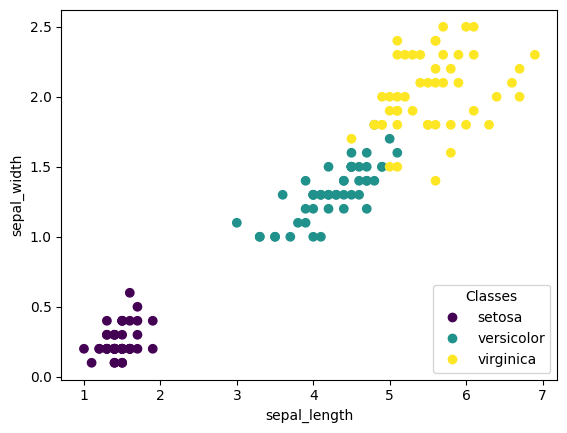

In [16]:
iris   = datasets.load_iris()
X_iris = iris.data[:, 2:]  # seulement les deux derniers attributs
Y_iris = iris.target

scatter = plt.scatter(X_iris[:, 0], X_iris[:, 1], c=Y_iris)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend(scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")
plt.show()

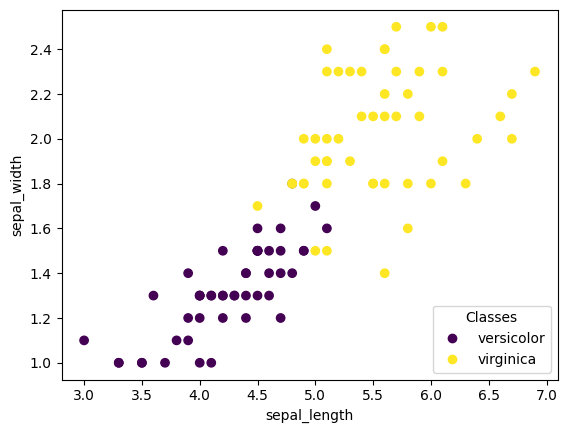

In [17]:
# supprimer les 50 premiers échantillons de "setosa"
X_irisBin = np.array(X_iris[51:, :])  # on prend les deux derniers attributs
Y_irisBin = np.array(Y_iris[51:])

# Les classes restantes ont les labels: "1" et "2"
# On les transforme à "0" et "1"
msk             = Y_irisBin == 1
Y_irisBin[ msk] = 0
Y_irisBin[~msk] = 1

scatter = plt.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend(scatter.legend_elements()[0], iris.target_names[1:], loc="lower right", title="Classes")
plt.show()


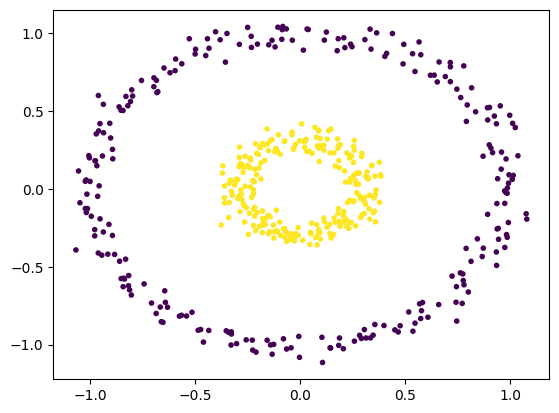

In [18]:


# generating data
X_circle, Y_circle = make_circles(n_samples = 500, noise = 0.05, factor=0.3)

# visualizing data
plt.scatter(X_circle[:, 0], X_circle[:, 1], c = Y_circle, marker = '.')
plt.show()

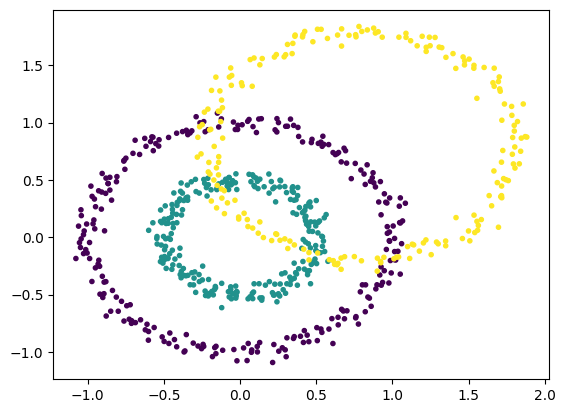

In [19]:
from sklearn.datasets import make_circles

# generating data
X_circle2, Y_circle2 = make_circles(n_samples = 500     , noise = 0.05, factor=0.5)
X_circle3, Y_circle3 = make_circles(n_samples = (200, 0), noise = 0.05, factor=0.2)

X_circle2 = np.concatenate((X_circle2, X_circle3 + 0.8), axis=0)
Y_circle2 = np.concatenate((Y_circle2, Y_circle3 + 2.0), axis=0)

# visualizing data
plt.scatter(X_circle2[:, 0], X_circle2[:, 1], c = Y_circle2, marker = '.')
plt.show()

### II.1. Stochastic Gradient Descent

We want to compare between GD and SGD in terms of cost convergence and training time.
To do this, we will compare between these methods:
- GD: Gradient Descent
- SGD: Stochastic Gradient Descent
- SGDA: Stochastic Gradient Descent with All samples

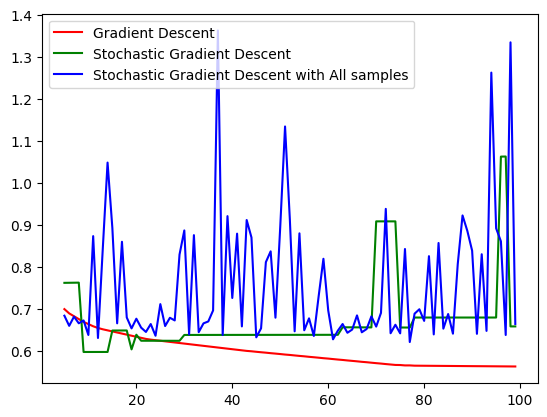

In [20]:
NBR_IT = 100
ALPHA  = 0.1
C      = 10.
D_IT   = 5
Its    = range(D_IT, NBR_IT)
# Increasing the size of the dataset
# it will not affect the result in terms of convergence
# this is just to test the case with several samples
# the execution time of the "random" function in "SGD" will be negligible
X, Y = np.repeat(X_irisBin, 5, axis=0), np.repeat(Y_irisBin, 5, axis=0)

svm_gd      = SVM(max_iter=NBR_IT, alpha=ALPHA, C=C)
temps_debut = timeit.default_timer()
couts_gd    = svm_gd.fit(X, Y)
temps_gd    = timeit.default_timer() - temps_debut

svm_sgd     = SVM(max_iter=NBR_IT, alpha=ALPHA, C=C, solver="SGD")
temps_debut = timeit.default_timer()
couts_sgd   = svm_sgd.fit(X, Y)
temps_sgd   = timeit.default_timer() - temps_debut

svm_sgda    = SVM(max_iter=NBR_IT, alpha=ALPHA, C=C, solver="SGDA")
temps_debut = timeit.default_timer()
couts_sgda  = svm_sgda.fit(X, Y)
temps_sgda  = timeit.default_timer() - temps_debut



plt.plot(Its, couts_gd  [D_IT:], color="red"  , label="Gradient Descent")
plt.plot(Its, couts_sgd [D_IT:], color="green", label="Stochastic Gradient Descent")
plt.plot(Its, couts_sgda[D_IT:], color="blue" , label="Stochastic Gradient Descent with All samples")
plt.legend()
plt.show()

In [21]:
pd.DataFrame({
    "Criteria" : ["Train time"],
    "GD"      : [temps_gd            ],
    "SGD"     : [temps_sgd           ],
    "SGDA"    : [temps_sgda          ],
})

,Criteria,GD,SGD,SGDA
0,Train time,0.129997,0.148047,3.976951


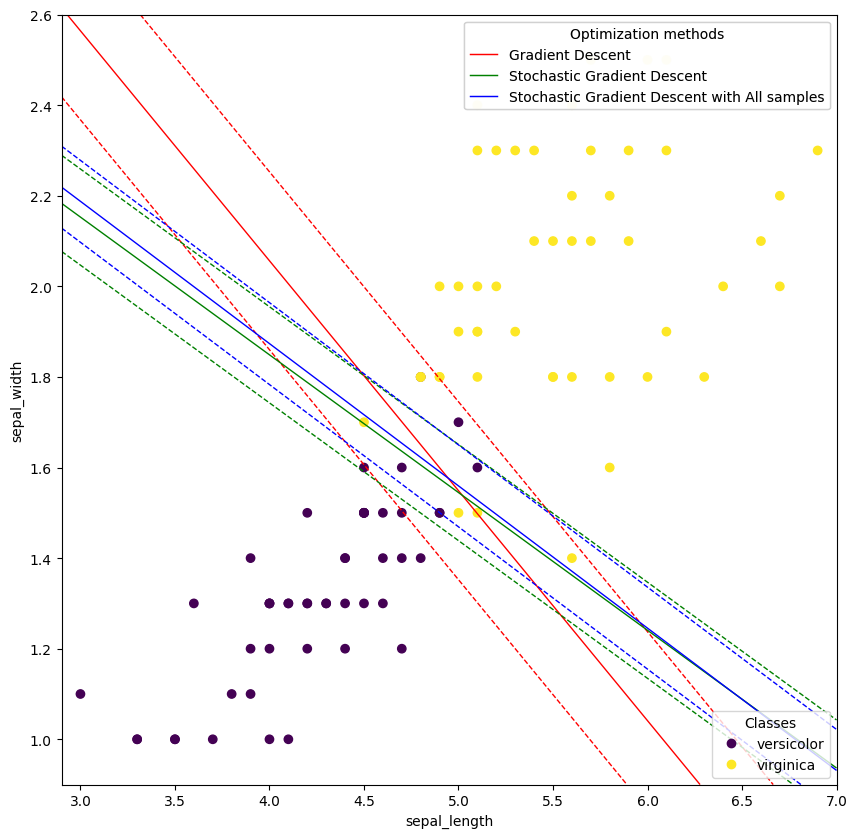

In [22]:
def draw(model, ax, xx, xy, color="r", label=""):

    # create a grid with estimates on xx and xy
    grid = [[model.predict(np.array([[xr, yr]]), cls=False) for xr in xx] for yr in xy]
    # transform this grid into a matrix
    grid = np.array(grid).reshape(len(xx), len(xy))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xx, xy, grid, levels=[-1,0,1], linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=color)
    return Line2D([0, 1], [0, 0], linewidth=1, linestyle='-', color=color)


fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
legend1 = plt.legend(scatter.legend_elements()[0], iris.target_names[1:], loc="lower right", title="Classes")


# generate 100 points between the min and the max of attribute X[0]
xx = np.linspace(X_irisBin[:,0].min() - .1, X_irisBin[:,0].max() + .1, 100)
# generate 100 points between the min and the max of attribute X[1]
xy = np.linspace(X_irisBin[:,1].min() - .1, X_irisBin[:,1].max() + .1, 100)

mthds = []
mthds.append(draw(svm_gd  , ax, xx, xy, color="red"  ))
mthds.append(draw(svm_sgd , ax, xx, xy, color="green"))
mthds.append(draw(svm_sgda, ax, xx, xy, color="blue" ))

mthds_lbl = [
    "Gradient Descent",
    "Stochastic Gradient Descent",
    "Stochastic Gradient Descent with All samples"
]
legend2 = plt.legend(mthds, mthds_lbl, loc="upper right", title="Optimization methods")
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.show()

**TODO: Analyze the results**

1. We notice that the graph of J_GD is smooth unlike the other two. Why ?
1. Does SGD show an advantage when there are local optima? How ?
1. How can we make the SGD graph smoother (without changing the algorithm)?
1. We notice that the training time is of the order: t_SGD < t_GD << t_SGDA. Why?
1. We notice that the linear separation graph of SGD is close to that of GD. Will SGD converge by only increasing the number of iterations or do we need other configurations? Please specify.

**Answers**

1. The graph of J_GD is smooth compared to the other two (the SGDs) because, in gradient descent, the parameters are updated using the average of the gradients calculated over the entire training dataset at each iteration. This allows for more precise and consistent updates of the parameters, generally leading to a smoother convergence of the optimization process.In contrast, in stochastic sub-gradient descent methods, the parameters are updated based on a single random sample at a time in SGDA, or a random order of training examples in the case of SGD. This can result in noisier and more irregular updates (as they depend on the chosen element and order), leading to larger fluctuations in the cost function values at each iteration and resulting in a bumpier graph of the cost function.
1. Yes, stochastic sub-gradient descent (SGD) can have advantages when there are local optima in the cost function. Since SGD updates the parameters based on a single sample at a time, it has the ability to explore different local optima more dynamically and can escape some undesirable local minima. In contrast, gradient descent (GD) might be more likely to get stuck in a local minimum.
1. To make the graph of SGD smoother without modifying the algorithm itself, you can account for the inherent random variations in stochastic descent by using smoothing techniques. For example, instead of plotting the cost for each individual iteration, you can perform averaging over multiple iterations to obtain an average cost.
1. The training time follows the order: t_SGD < t_GD << t_SGDA.
 , because we have limited the same number of iterations for each algorithm, so we compare their process at each iteration:

  SGD is the fastest because at each iteration it performs the necessary calculations on only a single sample.
  Next is GD, which is faster in terms of training time than SGDA. In GD, at each iteration, it goes through the entire training dataset to calculate the prediction error for each sample and then updates the parameters (thetas) using the average error.
  SGDA takes the longest time because, at each iteration, it not only goes through the entire training dataset but also updates the parameters for each sample individually, thus taking more time due to the multiple updates per iteration.
1. To improve SGD so that it converges more quickly to a more optimal solution and approaches the performance of GD, several techniques can be considered:

    Increasing the Number of Iterations: While this might seem like a straightforward approach, it doesn't guarantee optimal convergence. As the number of iterations increases, SGD tends to perform more parameter updates, which can introduce variability due to its random nature. This variability can lead to oscillations and fluctuations in the convergence process, making it slower and less stable.

    Using Mini-Batches: Instead of updating parameters using a single sample at each iteration, using mini-batches (a subset of samples) can improve accuracy per iteration and reduce fluctuations in the graph. This approach balances the benefits of both SGD and GD, offering a middle ground in terms of stability and computational efficiency.

    Adjusting the Learning Rate (Alpha): The learning rate is crucial in the learning process. Its value should not be chosen the same way as for GD because SGD handles individual samples differently than the average error across the entire dataset. Techniques such as learning rate schedules or adaptive learning rates (like those used in algorithms such as Adam) can help maintain convergence stability.

    Other Factors:

    Initialization of Model Parameters: Proper initialization can significantly impact the convergence speed and stability.
    Regularization Techniques: Applying regularization can help prevent overfitting and ensure smoother convergence.
    Hyperparameter Tuning: Proper selection and tuning of hyperparameters are essential for optimizing the performance of SGD.

### II.2. "primal" vs. "dual" forms

In this experiment, we want to compare the two forms "primal" and "dual" in the context of binary classification.
The criteria used for this comparison are:
- Training time
- Prediction time
- Model size

In [25]:
ALPHA = 0.1
C     = 10.

# Increasing the size of the dataset
# it will not affect the result in terms of convergence
# this is just to test the case with several samples
# the execution time of the "random" function in "SGD" will be negligible
X, Y = np.repeat(X_irisBin, 5, axis=0), np.repeat(Y_irisBin, 5, axis=0)

primal_stats = []
dual_stats   = []

#=========== PRIMAL =======================
svm_primal  = SVM(max_iter=10, alpha=ALPHA, C=C)
temps_debut = timeit.default_timer()
svm_primal.fit(X, Y)
primal_stats.append(timeit.default_timer() - temps_debut)
#-------------------------------------------
temps_debut = timeit.default_timer()
Y_primal    = svm_primal.predict(X)
primal_stats.append(timeit.default_timer() - temps_debut)
#-------------------------------------------
primal_stats.append(get_size(svm_primal))
#-------------------------------------------
#primal_stats.append(accuracy_score(Y, Y_primal))

#=========== DUAL =======================
svm_dual    = SVM(dual=True, C=C, tol = 0.001)
temps_debut = timeit.default_timer()
svm_dual.fit(X, Y)
dual_stats.append(timeit.default_timer() - temps_debut)
#-------------------------------------------
temps_debut = timeit.default_timer()
Y_dual      = svm_dual.predict(X)
dual_stats.append(timeit.default_timer() - temps_debut)
#-------------------------------------------
dual_stats.append(get_size(svm_dual))
#-------------------------------------------
#dual_stats.append(accuracy_score(Y, Y_dual))

pd.DataFrame({
    "Criteria" : ["Train time", "Prediction time", "Size"], #, "Accurracy train"
    "Primal"  : primal_stats,
    "Dual"    : dual_stats,
})

,Criteria,Primal,Dual
0,Train time,0.018855,634.159618
1,Prediction time,0.000147,0.509393
2,Size,2476.000000,50816.000000


**TODO: Analyze the results**

1. We notice that the training time t_primal << t_dual. Why?
1. Same remark and question for the prediction time.
1. We notice that the size of the S_primal << S_dual models. Why (detail)?
1. It seems that the "dual" form is bad based on these criteria, in this case, why is it used?

**Answers**

1. The training time
t_primal
​is much less than t_dual

  because solving the dual problem requires more iterations and computations than solving the primal problem.
1. The prediction time t_primal is less than
t_dual
  because the dual formulation requires additional computations to obtain predictions from the Lagrange multipliers. This can result in a slight increase in prediction time compared to the primal formulation, which can directly obtain predictions from the weights and bias.
1. The model size

  S_primal is much smaller than
  S_dual for several reasons:

    The dual form is known to generate a higher number of support vectors than the primal form. In the primal form, only the support vectors contribute to the model parameters, but in the dual form, all training vectors have an associated Lagrange multiplier. Thus, if the dual form generates a larger number of support vectors, it leads to an increase in the model size compared to the primal form.

    The dual form often uses a kernel transformation to enable nonlinear data separation in a higher-dimensional space. The dimension of the dual space is related to the complexity of data features and the choice of kernel used. If the dimension of the dual space is higher, it can result in an increase in the model size.
1. Despite these drawbacks, the dual form is used for several reasons:

  The kernel transformation used in the dual formulation allows for data projection into high-dimensional spaces. This enables more flexible decision boundaries, which can lead to better prediction performance in certain cases.

  It handles data that is not linearly separable in the original feature space. By using appropriate kernel functions, SVM can learn nonlinear relationships between features and class labels.

  The dual formulation allows for the use of various kernel functions, such as linear kernel, polynomial kernel, and radial basis function (RBF) kernel. This flexibility allows the SVM model to adapt to different data structures and capture complex relationships between features and class labels.

### II.3. C parameter

To test the effect of the C hyper-parameter, we will use **sklearn.svm.SVC** which is based on **LIBSVC** (SMO: Sequential minimal optimization). We noticed that the execution time is not stable in each execution. So, the idea to fix this is to run the same experiment over several trials and try to keep the average times.

So, to test the effect of parameter C, we drew 2 diagrams:
- The prediction margins for some values of C (on binary Iris, to better visualize the separation)
- Training time compared to C values (on Iris 3 classes, to have more data)

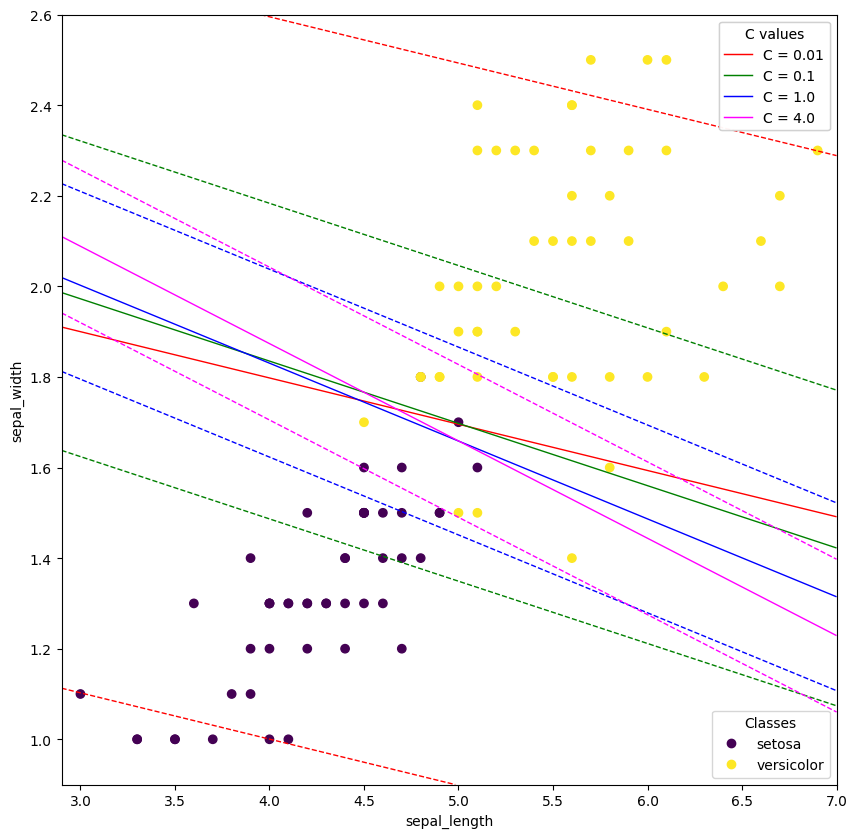

In [26]:
def draw_sklearn0(model, ax, xx, xy, color="r", label=""):

    Z    = model.decision_function(np.array(np.meshgrid(xx, xy)).T.reshape(-1, 2))
    grid = np.array(Z).reshape(len(xx), len(xy))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xx, xy, grid, levels=[-1,0,1], linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=color)
    return Line2D([0, 1], [0, 0], linewidth=1, linestyle='-', color=color)

fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
legend1 = plt.legend(scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")

# generate 100 points between the min and the max of attribute X[0]
xx = np.linspace(X_irisBin[:,0].min() - .1, X_irisBin[:,0].max() + .1, 100)
# generate 100 points between the min and the max of attribute X[1]
xy = np.linspace(X_irisBin[:,1].min() - .1, X_irisBin[:,1].max() + .1, 100)

Csp       = [0.01, 0.1, 1., 4.]
mthds     = []
mthds_lbl = []
Couleurs  = ["red", "green", "blue", "magenta"]

for Cp, couleur in zip(Csp, Couleurs):
    modele = SVC(C=Cp, kernel="linear", random_state=0, probability=True)
    modele.fit(X_irisBin, Y_irisBin)
    a = draw_sklearn0(modele, ax, xx, xy, color=couleur)
    mthds.append(a)
    mthds_lbl.append("C = " + str(Cp))

legend2 = plt.legend(mthds, mthds_lbl, loc="upper right", title="C values")
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.show()

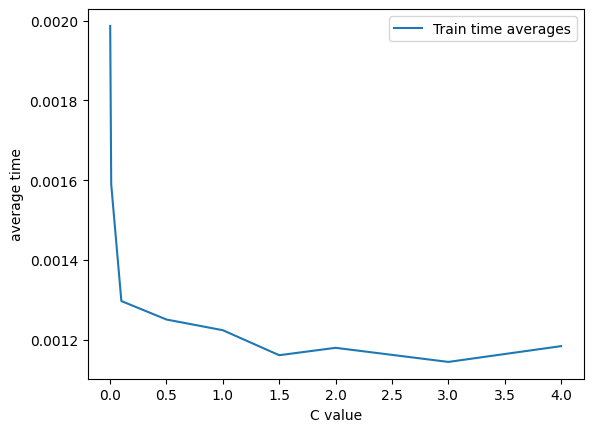

In [27]:
TRIALS = 50

X, Y = np.repeat(X_iris, 1, axis=0), np.repeat(Y_iris, 1, axis=0)
#X, Y = X_circle2, Y_circle2

# normalisateur = StandardScaler()
# X = normalisateur.fit_transform(X)

Cs       = [0.001, 0.01, 0.1, 0.5, 1., 1.5, 2., 3, 4]
Tr_stats = []

for tr in range(TRIALS):
    Cs_stats = []
    Tr_stats.append(Cs_stats)
    for C in Cs:
        modele      = SVC(C=C, kernel="linear", random_state=0)
        temps_debut = timeit.default_timer()
        modele.fit(X, Y)
        Cs_stats.append(timeit.default_timer() - temps_debut)


Temps_moy = np.mean(Tr_stats, axis=0)
plt.plot(Cs, Temps_moy, label="Train time averages")
plt.xlabel("C value")
plt.ylabel("average time")
plt.legend()
plt.show()


**TODO: Analyze the results**

1. What is the effect of the C value on the prediction margins?
1. We notice (in general) that the training time decreases with large values of **C**. How **C** can affect this time?

**Answers**

1. we observe that:

  A higher value of C leads to narrower prediction margins, meaning the model will be stricter in its classification and result in precise classification of training samples.

  A lower value of C allows for wider margins, meaning the model will be more tolerant of training errors and may misclassify some training samples.
1. Increasing the value of  C can result in reduced training times due to several factors:

  A higher C imposes a stronger penalty on training errors, leading to more effective regularization of the model. This helps prevent overfitting, which in turn can accelerate the convergence of the optimization process.

  Larger C values typically lead to a smaller number of support vectors, as only the most relevant training samples are considered significant. This reduction in the number of support vectors reduces the complexity of the model and can contribute to faster training.

  When the margin between classes is well-defined and distinct, a higher C value aids in faster convergence because it provides clearer guidance for class separation, reducing ambiguity and speeding up the learning process.

### II.4. Kernel choice

In this experiment, we want to test the effect of kernel choice for a certain problem. We will use multiclass Iris dataset where kernels will be evalued based on:
- Model separation (visualization)
- F-1 convergence score
- Training time

Used kernels are:
- **linear**: a linear kernel
- **poly**: a polynomial kernel with a degree 4
- **rbf**: a radial core (Radial Basis Function)
- **cosine**: a kernel with cosine similarity between samples

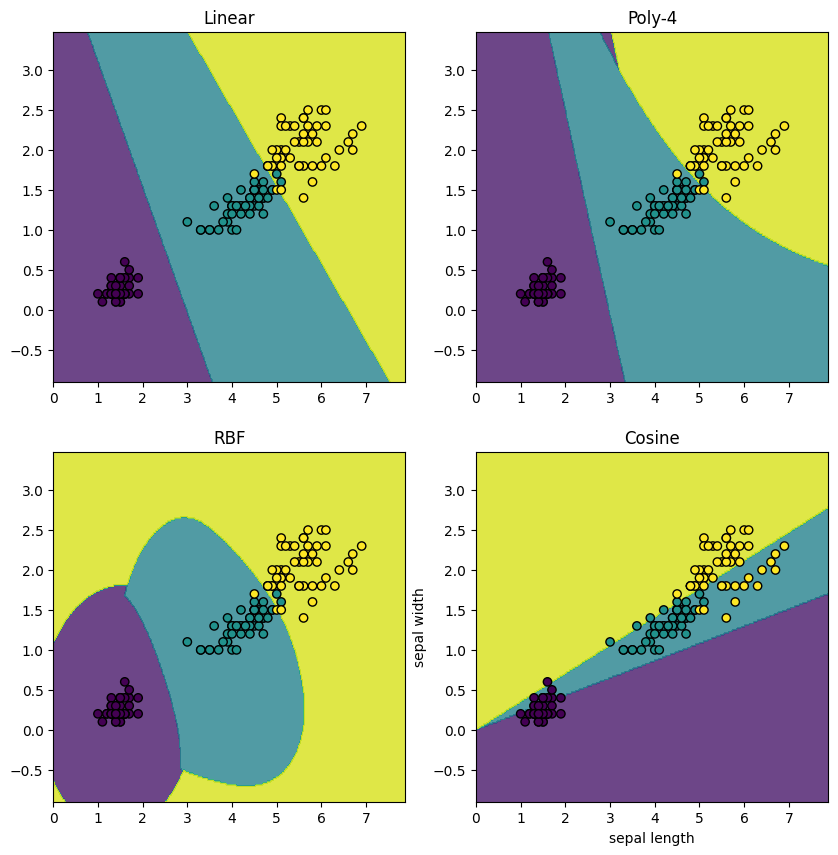

In [28]:
# Test inspired by https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html

def draw_sklearn(model, ax, xx, xy, X, Y, label=""):

    Z   = model.predict(np.c_[xx.ravel(), xy.ravel()])
    Z   = Z.reshape(xx.shape)
    out = ax.contourf(xx, xy, Z, alpha=0.8)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k")
    plt.xlabel("sepal length")
    plt.ylabel("sepal width")
    ax.set_title(label)



models = [
    SVC(kernel="linear"         , random_state=0, probability=True           ),
    SVC(kernel="poly"           , random_state=0, probability=True, degree=4 ),
    SVC(kernel="rbf"            , random_state=0, probability=True, gamma=0.7),
    SVC(kernel=cosine_similarity, random_state=0, probability=True           ),
]

labels = [
    "Linear",
    "Poly-4",
    "RBF"   ,
    "Cosine"
]

temps_kernel = []


fig, axs = plt.subplots(2, 2, figsize=(10,10))


xx_min, xx_max = X_iris[:, 0].min() - 1, X_iris[:, 0].max() + 1
xy_min, xy_max = X_iris[:, 1].min() - 1, X_iris[:, 1].max() + 1
xx, xy = np.meshgrid(np.arange(xx_min, xx_max, .02), np.arange(xy_min, xy_max, .02))

for model, label, ax in zip(models, labels, axs.flatten()):
    temps_debut = timeit.default_timer()
    model.fit(X_iris, Y_iris)
    temps_kernel.append(timeit.default_timer() - temps_debut)
    draw_sklearn(model, ax, xx, xy, X_iris, Y_iris, label=label)

plt.show()

In [29]:
perf = []

for model in models:
    perf.append(f1_score(Y_iris, model.predict(X_iris), average="micro"))

pd.DataFrame({
    "Kernel"                : labels,
    "Train F1 score"      : perf,
    "Train time" : temps_kernel
})

,Kernel,Train F1 score,Train time
0,Linear,0.966667,0.002699
1,Poly-4,0.960000,0.002654
2,RBF,0.966667,0.002678
3,Cosine,0.780000,0.006416


**TODO: Analyze the results**

1. Based on the decision lines and the F1-score, what is the best kernel for this problem in your opinion?
1. Why?

**Answers**

1. Based on the decision lines and the F1-score, the best kernel for this problem appears to be the RBF (Radial Basis Function) kernel.
2. The RBF kernel achieves the highest F1-score of 0.96667, which is tied with the linear kernel. However, the visualization of the decision boundaries suggests that the RBF kernel provides better separation between the classes compared to the linear kernel. The RBF kernel's decision boundary is non-linear, which allows it to better capture the underlying patterns in the data, especially when the classes are not linearly separable.
The polynomial kernel (poly-4) also achieves a relatively high F1-score of 0.96, but it may be more prone to overfitting, especially with higher degrees. The cosine kernel, on the other hand, has the lowest F1-score of 0.78, indicating that it may not be suitable for this particular problem.
Additionally, the training time for the RBF kernel is comparable to the other kernels, so there is no significant trade-off in terms of computational efficiency.

### II.5. Problem complexity

Here, we want to test the effect of the complexity of the problem on the separation, as well as the parameterization. We will use the **RBF** kernel which is more flexible and which supports more complex problems (non-linearly separable). We will use two criteria in this experiment:
- F1-convergence score
- Separation between classes (visualization)

The addressed problems are:
- **Iris**: linear separation between 3 classes
- **Iris 2 classes**: binary linear separation
- **Circle 2 classes**: binary radial separation
- **3-class circle with overlap**: radial separation, but with overlap between classes (here, slightly different configuration for RBF)

In [30]:
rbf2 = SVC(kernel="rbf", random_state=0, gamma=0.7, probability=True)
rbf3 = SVC(kernel="rbf", random_state=0, gamma=0.7, probability=True)
rbf4 = SVC(kernel="rbf", random_state=0, gamma=10., probability=True)

rbf2.fit(X_irisBin, Y_irisBin)
rbf3.fit(X_circle, Y_circle)
rbf4.fit(X_circle2, Y_circle2)

perf2 = []
perf2.append(f1_score(Y_iris   , models[2].predict(X_iris) , average="micro"))
perf2.append(f1_score(Y_irisBin, rbf2.predict(X_irisBin)   , average="micro"))
perf2.append(f1_score(Y_circle , rbf3.predict(X_circle)    , average="micro"))
perf2.append(f1_score(Y_circle2, rbf4.predict(X_circle2)   , average="micro"))

pd.DataFrame({
    "Problem"        : ["Iris", "Iris 2 classes", "Circles", "Circles 3 classes"],
    "F1 train" : perf2
})

,Problem,F1 train
0,Iris,0.966667
1,Iris 2 classes,0.949495
2,Circles,1.000000
3,Circles 3 classes,0.951429


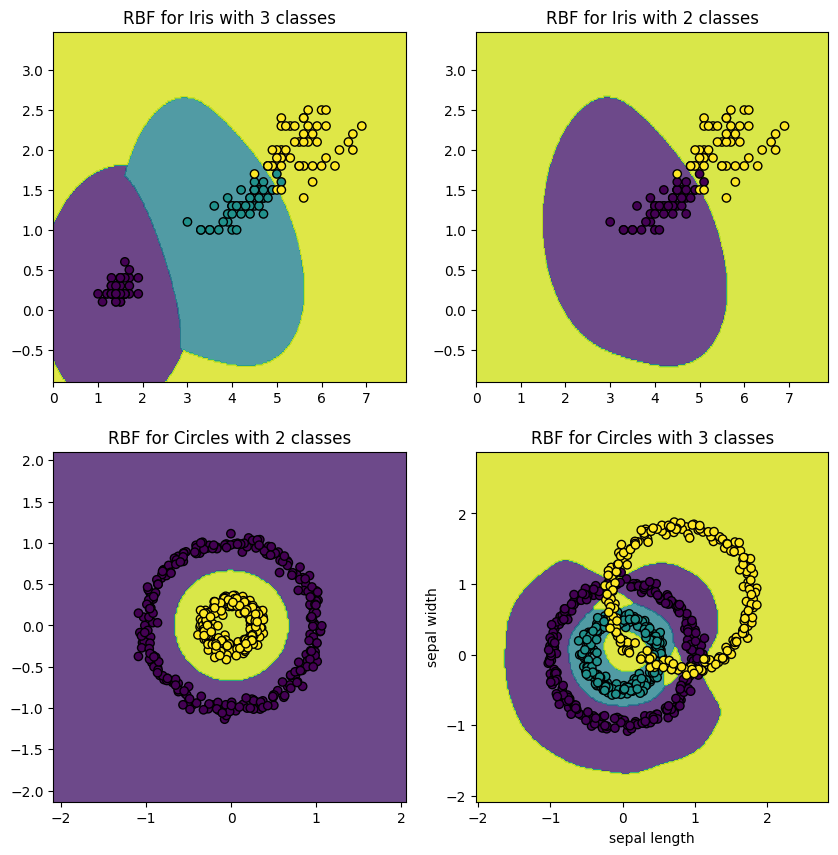

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))


draw_sklearn(models[2], ax1, xx, xy, X_iris, Y_iris, label="RBF for Iris with 3 classes")
draw_sklearn(rbf2, ax2, xx, xy, X_irisBin, Y_irisBin, label="RBF for Iris with 2 classes")

xx_min3, xx_max3 = X_circle[:, 0].min() - 1, X_circle[:, 0].max() + 1
xy_min3, xy_max3 = X_circle[:, 1].min() - 1, X_circle[:, 1].max() + 1
xx3, xy3 = np.meshgrid(np.arange(xx_min3, xx_max3, .02), np.arange(xy_min3, xy_max3, .02))
draw_sklearn(rbf3, ax3, xx3, xy3, X_circle, Y_circle, label="RBF for Circles with 2 classes")

xx_min4, xx_max4 = X_circle2[:, 0].min() - 1, X_circle2[:, 0].max() + 1
xy_min4, xy_max4 = X_circle2[:, 1].min() - 1, X_circle2[:, 1].max() + 1
xx4, xy4 = np.meshgrid(np.arange(xx_min4, xx_max4, .02), np.arange(xy_min4, xy_max4, .02))
draw_sklearn(rbf4, ax4, xx4, xy4, X_circle2, Y_circle2, label="RBF for Circles with 3 classes")

plt.show()

**TODO: Analyze the results**

1. Why does the model converge better on "Circle 2 classes" despite the fact that it is a more complex problem than the two linearly separable problems?
1. Why does the model give a better F1-score on "Iris" than "Iris 2 classes" despite the latter being a simpler problem?

**Answers**

1. The model converges better on the "Circle 2 classes" problem despite its higher complexity because the RBF kernel is specifically designed to handle non-linear, circularly separable data. The RBF kernel computes similarity between samples based on their distance, making it well-suited for problems where classes form distinct radial clusters or patterns. This explains why it achieves a perfect F1-score of 1.0 on the "Circle 2 classes" dataset.
2. Regarding the lower F1-score on the "Iris 2 classes" problem compared to the "Iris" problem with 3 classes, there could be a few potential reasons:
a. Overlap between classes: As seen in the visualization, there is some overlap between the two classes in the "Iris 2 classes" problem, which makes it harder for the model to find a clean decision boundary, even though it's a binary classification task.
b. Class imbalance: If the two classes in the "Iris 2 classes" problem are imbalanced, it could make it more challenging for the model to learn an accurate decision boundary, leading to a lower F1-score.
c. Data representation: The features or the way the data is represented for the "Iris 2 classes" problem may not be as discriminative or informative as the original "Iris" dataset with 3 classes. This could make it harder for the model to separate the classes effectively.